In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


mod_press = np.genfromtxt('mod_pressure.csv', delimiter=',')
volum = np.genfromtxt('volum.csv', delimiter=',')
temp = np.genfromtxt('temp.csv', delimiter=',')
volums = []
for v in volum:
    k = [v for i in range(len(mod_press)//len(volum))]
    volums += k
len(volums)
volum = np.array(volums)
df = pd.DataFrame(data={'v':volum, 'temprature':temp})
nparray = df.values

X_train = torch.from_numpy(nparray)
y_train = torch.from_numpy(mod_press)

Learned R: 15.5246
True R: 287.0


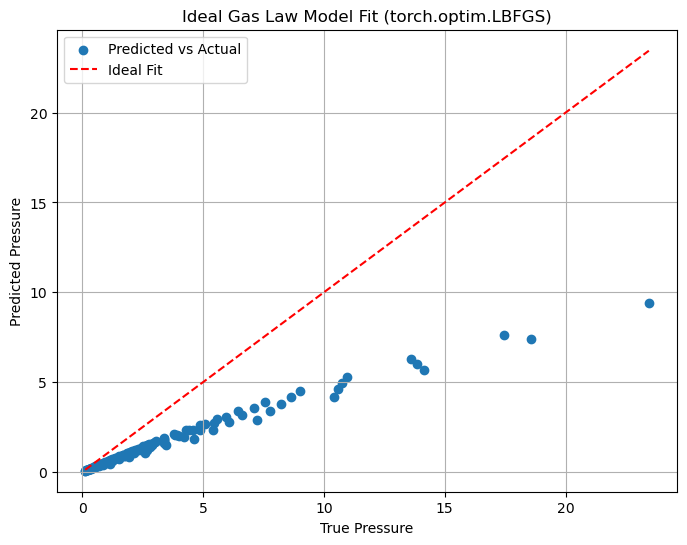

In [4]:
# 1. Define the Ideal Gas Law model
class IdealGasLaw(nn.Module):
    def __init__(self):
        super(IdealGasLaw, self).__init__()
        # Initialize R with a wrong guess
        self.R = nn.Parameter(torch.tensor([230.0], dtype=torch.float64))  # True value ~ 287 J/(kg*K)

    def forward(self, x):
        v = x[:, 0]  # Volume
        t = x[:, 1]  # Temperature
        p = self.R * t / v
        return torch.reshape(p, (-1, 1))  # Shape (n_samples, 1)

# 2. Create synthetic data
torch.manual_seed(0)


true_R = 287.0  # True value of R


# 3. Instantiate the model
model = IdealGasLaw()

# 4. Define the loss (residual sum of squares)
def loss_fn():
    y_pred = model(X_train)
    residuals = y_pred - y_train
    return torch.sum(residuals ** 2)

# 5. Set up the optimizer
optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, tolerance_grad=1e-09, tolerance_change=1e-09)
# 6. Optimization step
def closure():
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    return loss

# Optimize
optimizer.step(closure)

# 7. Show result
print(f"Learned R: {model.R.item():.4f}")
print(f"True R: {true_R}")

# 8. Optional: Plot predicted vs actual
with torch.no_grad():
    preds = model(X_train)

plt.figure(figsize=(8,6))
plt.scatter(y_train.numpy(), preds.numpy(), label='Predicted vs Actual')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', label='Ideal Fit')
plt.xlabel('True Pressure')
plt.ylabel('Predicted Pressure')
plt.legend()
plt.title('Ideal Gas Law Model Fit (torch.optim.LBFGS)')
plt.grid(True)
plt.show()